# Visualize Experiment Results

In [1]:
import os
import re

import pandas as pd
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from data_imputation_paper.experiment import read_experiment, read_csv_files

# plotting settings
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Import the data

In [2]:
EXPERIMENT_PATH = Path("../data/experiments/cluster2/fully_observed/")

In [3]:
read_experiment(EXPERIMENT_PATH).head()

,experiment,imputer,task,missing_type,missing_fraction,strategy,file_or_dir,detail_file,path
0,fully_observed,AutoKerasImputer,32,MAR,0.01,single_all,downstream_performance_mean_input13.csv,,../data/experiments/cluster2/fully_observed/Au...
1,fully_observed,AutoKerasImputer,32,MAR,0.01,single_all,impute_performance_std_input13.csv,,../data/experiments/cluster2/fully_observed/Au...
2,fully_observed,AutoKerasImputer,32,MAR,0.01,single_all,downstream_performance_std_input13.csv,,../data/experiments/cluster2/fully_observed/Au...
3,fully_observed,AutoKerasImputer,32,MAR,0.01,single_all,impute_performance_mean_input13.csv,,../data/experiments/cluster2/fully_observed/Au...
4,fully_observed,AutoKerasImputer,32,MAR,0.01,single_all,input13,impute_performance_rep_2.csv,../data/experiments/cluster2/fully_observed/Au...


In [4]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH))
results.drop("experiment", axis=1, inplace=True)
results.head()

CPU times: user 2min 47s, sys: 5.01 s, total: 2min 52s
Wall time: 3min


,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,AutoKerasImputer,32,MAR,0.01,single_all,input13,impute_performance,MAE,9.223112,25.882530,NaN,NaN,NaN
1,AutoKerasImputer,32,MAR,0.01,single_all,input13,impute_performance,MSE,209.169897,669.905370,NaN,NaN,NaN
2,AutoKerasImputer,32,MAR,0.01,single_all,input13,impute_performance,RMSE,14.462707,25.882530,NaN,NaN,NaN
3,AutoKerasImputer,32,MAR,0.01,single_all,input13,impute_performance,MAE,11.538475,2.872540,NaN,NaN,NaN
4,AutoKerasImputer,32,MAR,0.01,single_all,input13,impute_performance,MSE,243.701213,8.251483,NaN,NaN,NaN


## Data wrangling

1. gruppieren nach allen experimental conditions und dann nur ueber alle repetitions schauen, was die ranks der einzelnen imputation methoden warn
2. diese ranks aggregieren

In [5]:
EXPERIMENTAL_CONDITIONS = ["task", "missing_type", "missing_fraction", "strategy", "column", "result_type", "metric"]

ranked_data = results.groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=False)
ranked_data = results.join(ranked_data, rsuffix="_rank")
ranked_data

,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed,train_rank,test_rank,baseline_rank,corrupted_rank,imputed_rank
0,AutoKerasImputer,32,MAR,0.01,single_all,input13,impute_performance,MAE,9.223112,25.882530,NaN,NaN,NaN,5.0,1.0,NaN,NaN,NaN
1,AutoKerasImputer,32,MAR,0.01,single_all,input13,impute_performance,MSE,209.169897,669.905370,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN
2,AutoKerasImputer,32,MAR,0.01,single_all,input13,impute_performance,RMSE,14.462707,25.882530,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN
3,AutoKerasImputer,32,MAR,0.01,single_all,input13,impute_performance,MAE,11.538475,2.872540,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN
4,AutoKerasImputer,32,MAR,0.01,single_all,input13,impute_performance,MSE,243.701213,8.251483,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127255,GAINImputer,1220,MNAR,0.10,single_all,depth,downstream_performance,F1_macro,NaN,NaN,0.476541,0.475945,0.475945,NaN,NaN,3.0,2.0,2.0
127256,GAINImputer,1220,MNAR,0.10,single_all,depth,downstream_performance,F1_weighted,NaN,NaN,0.761524,0.761384,0.761384,NaN,NaN,3.0,3.0,3.0
127257,GAINImputer,1220,MNAR,0.10,single_all,depth,downstream_performance,F1_micro,NaN,NaN,0.827034,0.827785,0.827785,NaN,NaN,3.0,2.0,2.0
127258,GAINImputer,1220,MNAR,0.10,single_all,depth,downstream_performance,F1_macro,NaN,NaN,0.476541,0.472925,0.472925,NaN,NaN,3.0,5.0,5.0


## Visualize Classification Downstream Performance

In [6]:
CLF_METRIC = "F1_macro"
RESULT_TYPE = "downstream_performance"

<AxesSubplot:title={'center':'Imputed Rank KDE'}, ylabel='Density'>

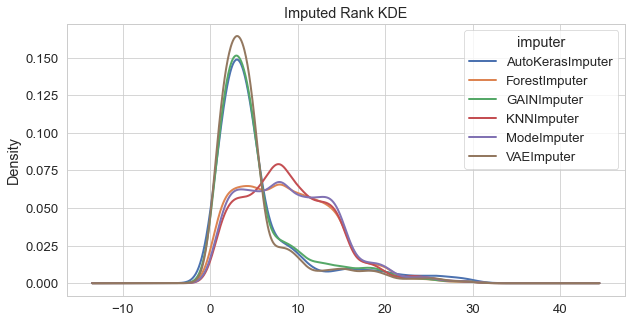

In [7]:
row_idx = (results["result_type"] == RESULT_TYPE) & (results["metric"] == CLF_METRIC)
plot_data = ranked_data.loc[row_idx, ["imputer", "imputed_rank"]]
plot_data = plot_data.pivot(columns="imputer", values="imputed_rank")

plot_data.plot(kind="kde", title="Imputed Rank KDE", figsize=(10,5))

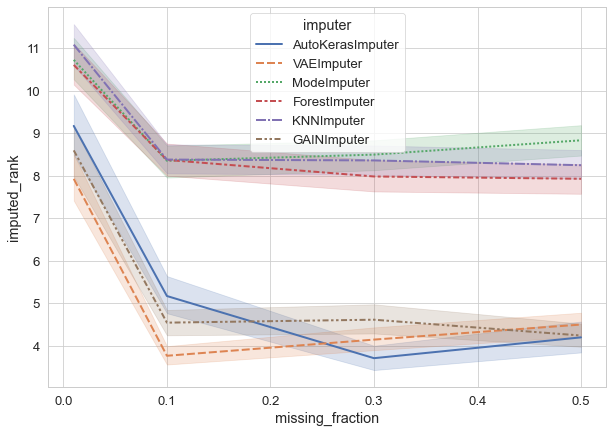

In [8]:
row_idx = (results["result_type"] == RESULT_TYPE) & (results["metric"] == CLF_METRIC)
plot_data = ranked_data.loc[row_idx]

plt.figure(figsize=(10,7))
ax = sns.lineplot(
    data=plot_data, 
    x="missing_fraction", 
    y="imputed_rank", 
    hue="imputer", 
    style="imputer"
)

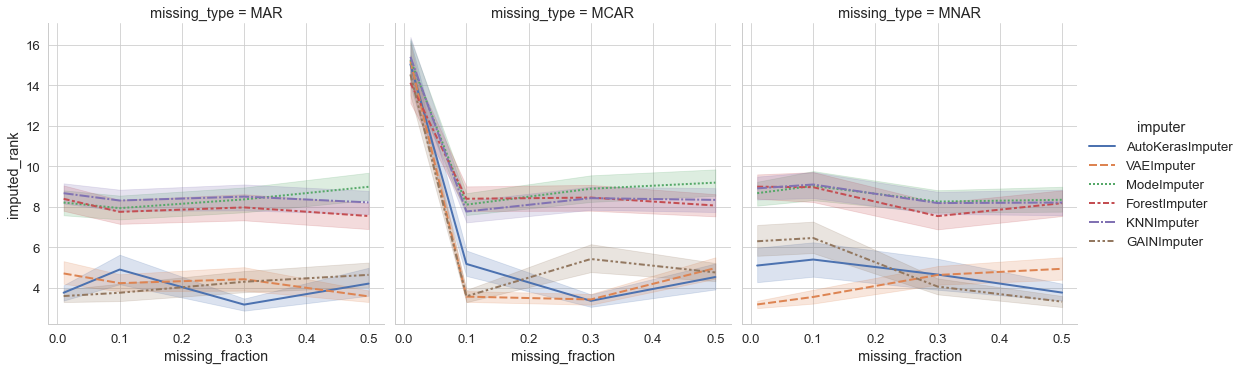

In [9]:
row_idx = (results["result_type"] == RESULT_TYPE) & (results["metric"] == CLF_METRIC)
plot_data = ranked_data[row_idx]

sns.relplot(
    data=plot_data, 
    x="missing_fraction", 
    y="imputed_rank", 
    hue="imputer", 
    style="imputer", 
    col="missing_type",
    kind="line"
)

## TODO

* make import faster / pickle
* (rank of) which metric is most relevant
  * classification: F1 macro?!
  * regression: RMSE?!
* export SVG
* plot other result types
* plot by strategy?
* *plot regression tasks*
* plot corrupted
* add basline (line)
* plot train, test?
* plot something for heterogenous datasets (mult-column performance)?
* check plots in other papers